# HuggingFace Finetuning Project

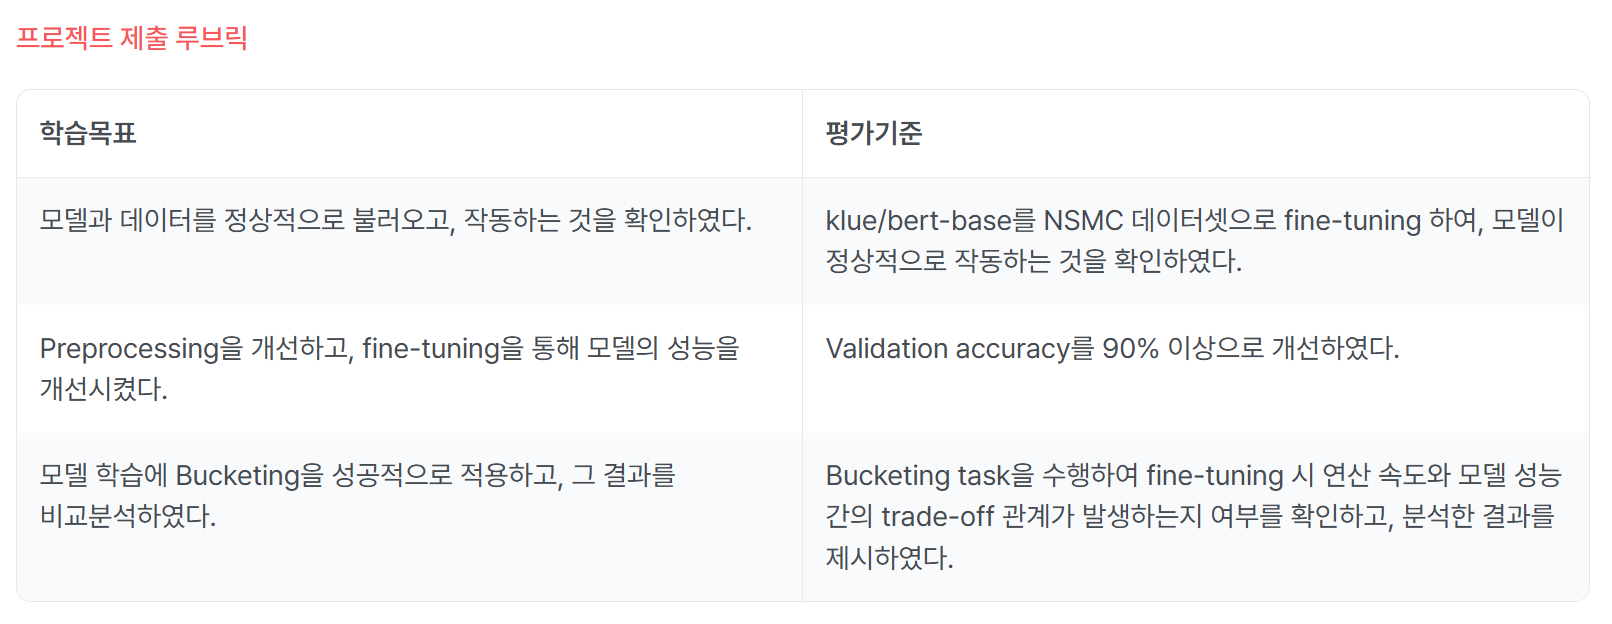

# Section 1. 라이브러리 설치 및 로드

In [ ]:
!pip install transformers datasets evaluate accelerate scikit-learn

In [2]:
import pandas as pd
import numpy as np

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

# Section 2. 데이터 로드 & EDA

In [3]:
# 데이터셋 로드
# NSMC 데이터셋의 원본 URL
train_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
test_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

# 구분자를 탭(\t)으로
dataset = load_dataset(
    "csv", 
    data_files={"train": train_url, "test": test_url}, 
    delimiter="\t",
    keep_default_na=False # 빈 문자열이 NaN으로 변환되는 것을 방지
)

# 데이터 구조 확인
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

# 데이터 예시 및 라벨 분포 확인
# 0: 부정, 1:긍정
df_train = pd.DataFrame(dataset['train'])
print("\n--- 데이터 예시 ---")
print(df_train.head())

print("\n--- 라벨 분포 ---")
print(df_train['label'].value_counts())

Train dataset size: 150000
Test dataset size: 50000

--- 데이터 예시 ---
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

--- 라벨 분포 ---
label
0    75173
1    74827
Name: count, dtype: int64


# Section 3. Model & Tokenizer 로드
klue/bert-base model, tokenizer 로드

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model_id = "klue/bert-base"

# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(model_id)

# model 로드
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2
).to(device)

Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Section 4. 데이터 전처리

In [5]:
# 전처리 함수
def preprocessing(examples):
    return tokenizer(
        examples["document"],
        truncation=True,
        max_length=128,
        padding=True
        # padding=False # dynamic padding 할 것이기 때문에 여기선 False
    )
    
# 전체 데이터셋에 적용
tokenized_datasets = dataset.map(preprocessing, batched=True)
print("Columns (Before):", tokenized_datasets['train'].column_names)

# 학습에 불필요한 칼럼 제거
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'document'])
print("Columns (After):", tokenized_datasets['train'].column_names)

# list -> tensor 변환
tokenized_datasets.set_format("torch")

print("Train dataset example:", tokenized_datasets['train'][0])

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Columns (Before): ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
Columns (After): ['label', 'input_ids', 'token_type_ids', 'attention_mask']
Train dataset example: {'label': tensor(0), 'input_ids': tensor([   2, 1376,  831, 2604,   18,   18, 4229, 9801, 2075, 2203, 2182, 4243,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Section 5. 모델 학습 (Baseline)

In [6]:
# Metric 로드
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# 학습 인자(args) 설정
training_args = TrainingArguments(
    output_dir = "models",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True, # GPU 메모리 절약 + 속도 향상
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    group_by_length=False # Bucketing 비교를 위해 여기선 False
)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 학습 진행
train_result_baseline = trainer.train()
metrics_baseline = train_result_baseline.metrics

print(f"Training Time: {metrics_baseline['train_runtime']:.2f} sec")
print(f"Final Accuracy: {trainer.evaluate()['eval_accuracy']:.4f}")

/tmp/ipykernel_2076/618037343.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247000,0.241034,0.902000
2,0.184800,0.243800,0.905480
3,0.116600,0.298962,0.905940


Training Time: 3072.16 sec


Final Accuracy: 0.9059


# Section 6. Bucketing & dynamic padding 적용

## Section 6.1 전처리 (패딩 미포함)

In [5]:
# 전처리 함수
def preprocessing_no_padding(examples):
    return tokenizer(
        examples["document"],
        truncation=True,
        max_length=128,
        # padding=True
        padding=False # dynamic padding 할 것이기 때문에 False
    )
    
# 전체 데이터셋에 적용
tokenized_datasets = dataset.map(preprocessing_no_padding, batched=True)
print("Columns (Before):", tokenized_datasets['train'].column_names)

# 학습에 불필요한 칼럼 제거
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'document'])
print("Columns (After):", tokenized_datasets['train'].column_names)

# list -> tensor 변환
tokenized_datasets.set_format("torch")

print("Train dataset example:", tokenized_datasets['train'][0])

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Columns (Before): ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
Columns (After): ['label', 'input_ids', 'token_type_ids', 'attention_mask']
Train dataset example: {'label': tensor(0), 'input_ids': tensor([   2, 1376,  831, 2604,   18,   18, 4229, 9801, 2075, 2203, 2182, 4243,
           3]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


## Section 6.2 모델 학습

In [9]:
# Metric 로드
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args_bucketing = TrainingArguments(
    output_dir = "models",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True, # GPU 메모리 절약 + 속도 향상
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    group_by_length=True # Bucketing
)

# Data Collator (dynamic padding 적용)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 모델 초기화
model_bucketing = AutoModelForSequenceClassification.from_pretrained(
    model_id, 
    num_labels=2
).to(device)

trainer_bucketing = Trainer(
    model=model_bucketing,
    args=training_args_bucketing,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 학습 진행
print("\n--- Bucketing 적용 학습 시작 ---")
train_result_d_b = trainer_bucketing.train()
metrics_d_b = train_result_d_b.metrics

print("\n=== Bucketing 적용 학습 결과 ===")
print(f"Training Time: {metrics_d_b['train_runtime']:.2f} sec")
print(f"Final Accuracy: {trainer_bucketing.evaluate()['eval_accuracy']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2826/1535689727.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bucketing = Trainer(



--- Bucketing 적용 학습 시작 ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.250500,0.242254,0.901980
2,0.175100,0.258474,0.904960
3,0.122400,0.295870,0.907060



=== Bucketing 적용 학습 결과 ===
Training Time: 1492.27 sec


Final Accuracy: 0.9071


# Section 7. 실험 결과

---

Baseline 모델과 dynamic padding과 Bucketing을 적용한 Advanced 모델의 학습 소요 시간과 정확도를 비교해 보았다.  
단, dynamic padding과 Bucketing 적용 여부 외의 모든 변인은 동일하게 했다.

| model | training Time | Validation Acc |
|:---------|--------:|--------------------------:|
| Baseline | 51 min | 0.9059 |
| Advanced | 25 min | 0.9071 |  

학습 결과, dynamic padding과 Bucketing 기법을 적용한 Advanced 모델이 baseline 모델에 비해 학습 소요 시간이 절반 가량 크게 감소한 것을 확인할 수 있었으며, Validation Accuracy 또한 미세하게 향상된 것을 확인할 수 있었다.

# Section 8. 회고

지금까지 토크나이저, 모델 등을 모두 직접 구현하고 바닥부터 학습시키다가 huggingface로 pretrined 토크나이저와 모델을 가져오니 신세계를 보았다. 학습 시간은 물론 성능이 이전과는 비교할 수 없을 정도로 좋아지니 참 마음이 편안했다. (실험 과정 자체도 코드가 훨씬 짧아지니 소요 시간도 줄어서 다른 공부를 할 여유가 늘어서 좋다.)